In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import matplotlib.image as mpimg
from PIL import Image

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

sample_df = pd.read_csv('sample_labels.csv')

def expand_labels(df, label_column):
    all_labels = np.unique(list(chain(*df[label_column].map(lambda x: x.split('|')).tolist())))
    all_labels = [x for x in all_labels if len(x) > 0]
    
    for c_label in all_labels:
        if len(c_label) > 1: # ignore empty labels
            df[c_label] = df[label_column].map(lambda finding: 1.0 if c_label in finding else 0)
    return df, all_labels

labels_col = "Finding Labels"

all_xray_df, all_labels = expand_labels(all_xray_df, labels_col)

all_xray_df['Disease Count'] = all_xray_df[labels_col].apply(lambda x: len(x.split('|')))
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].replace(r'\D', '', regex=True).astype(int)
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Disease Count
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


# Gender distribution

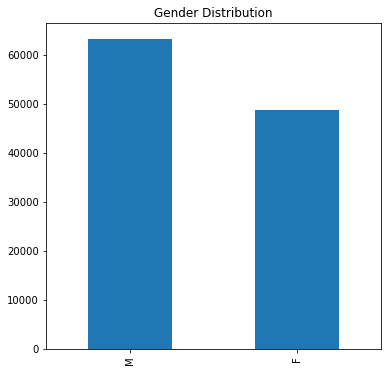

In [45]:
plt.figure(figsize=(6,6))
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')
plt.title('Gender Distribution')
plt.show()

# Age distribution

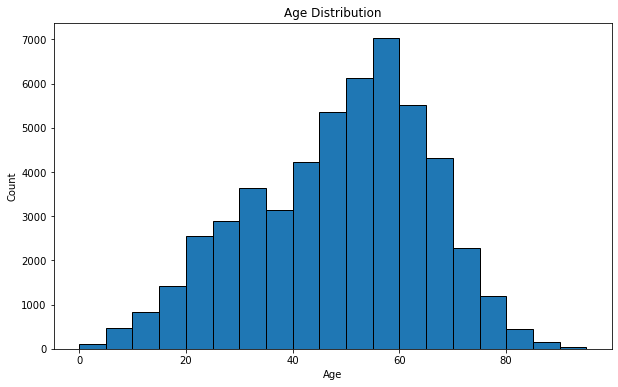

In [46]:
age_df = all_xray_df[all_xray_df[labels_col] != 'No Finding']
plt.figure(figsize=(10,6))
plt.hist(age_df['Patient Age'], bins=range(0,100,5), edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


# View position

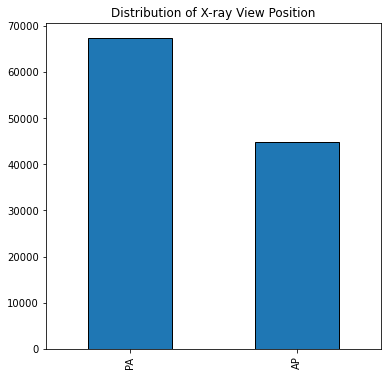

In [47]:
plt.figure(figsize=(6,6))
all_xray_df['View Position'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Distribution of X-ray View Position')
plt.show()

# Total Pneumonia Cases

In [49]:
pneumonia_cases = len(all_xray_df[all_xray_df['Pneumonia'] == 1.0])
print(f"Number of Pneumonia cases: {pneumonia_cases}")

Number of Pneumonia cases: 1431


# Total non-pneumonia cases

In [50]:
non_pneumonia_cases = len(all_xray_df[(all_xray_df['Pneumonia'] == 0.0) & (all_xray_df[labels_col] != 'No Finding')])
print(f"Number of Non-Pneumonia cases: {non_pneumonia_cases}")

Number of Non-Pneumonia cases: 50328


# Comorbid diseases with pneumonia

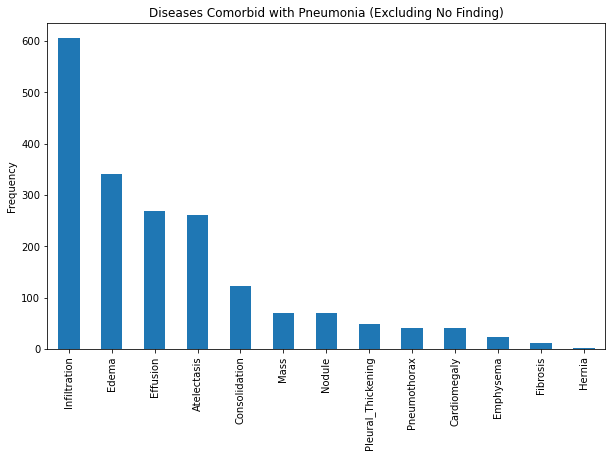

In [60]:
pneumonia_df = all_xray_df[all_xray_df['Pneumonia'] == 1.0]
comorbidity_df = pneumonia_df[all_labels].sum().sort_values(ascending=False)
comorbidity_df = comorbidity_df.drop(['Pneumonia', 'No Finding'])
comorbidity_df.plot(kind='bar', figsize=(10,6))
plt.title('Diseases Comorbid with Pneumonia (Excluding No Finding)')
plt.ylabel('Frequency')
plt.show()

# Total diseases per patient

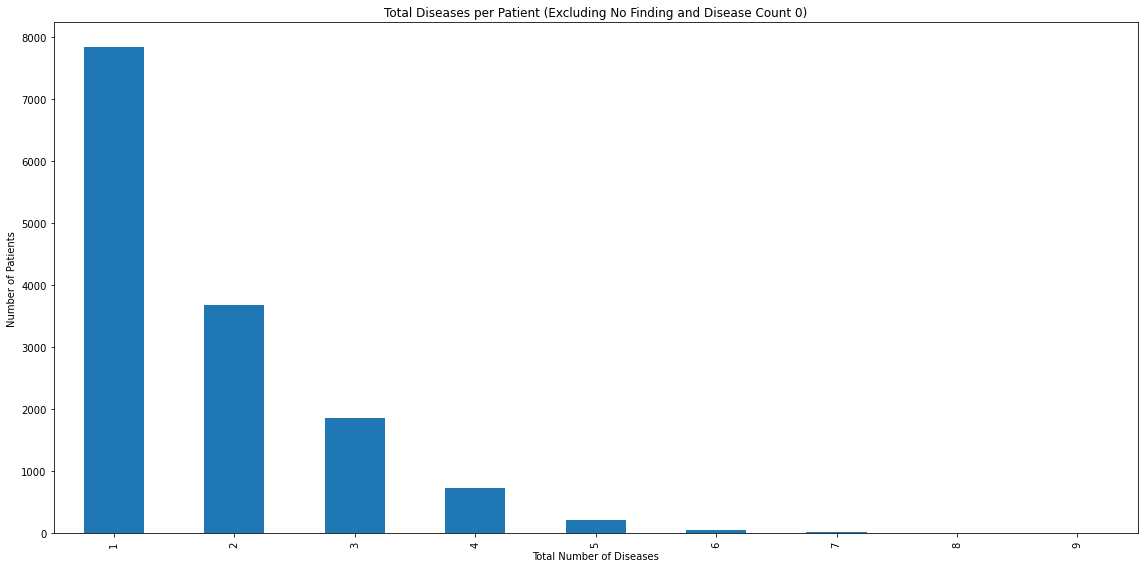

In [80]:
all_xray_df_grouped_by_patient = all_xray_df.groupby('Patient ID')
disease_per_patient = all_xray_df_grouped_by_patient['Disease Count'].max()

disease_per_patient = disease_per_patient[disease_per_patient > 0]  # Exclude where 'Disease Count' is 0

plt.figure(figsize=(16,8))
disease_per_patient.value_counts().sort_index().plot(kind='bar')
plt.title('Total Diseases per Patient (Excluding No Finding and Disease Count 0)')
plt.xlabel('Total Number of Diseases')
plt.ylabel('Number of Patients')
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()


# Pixel-level assessment

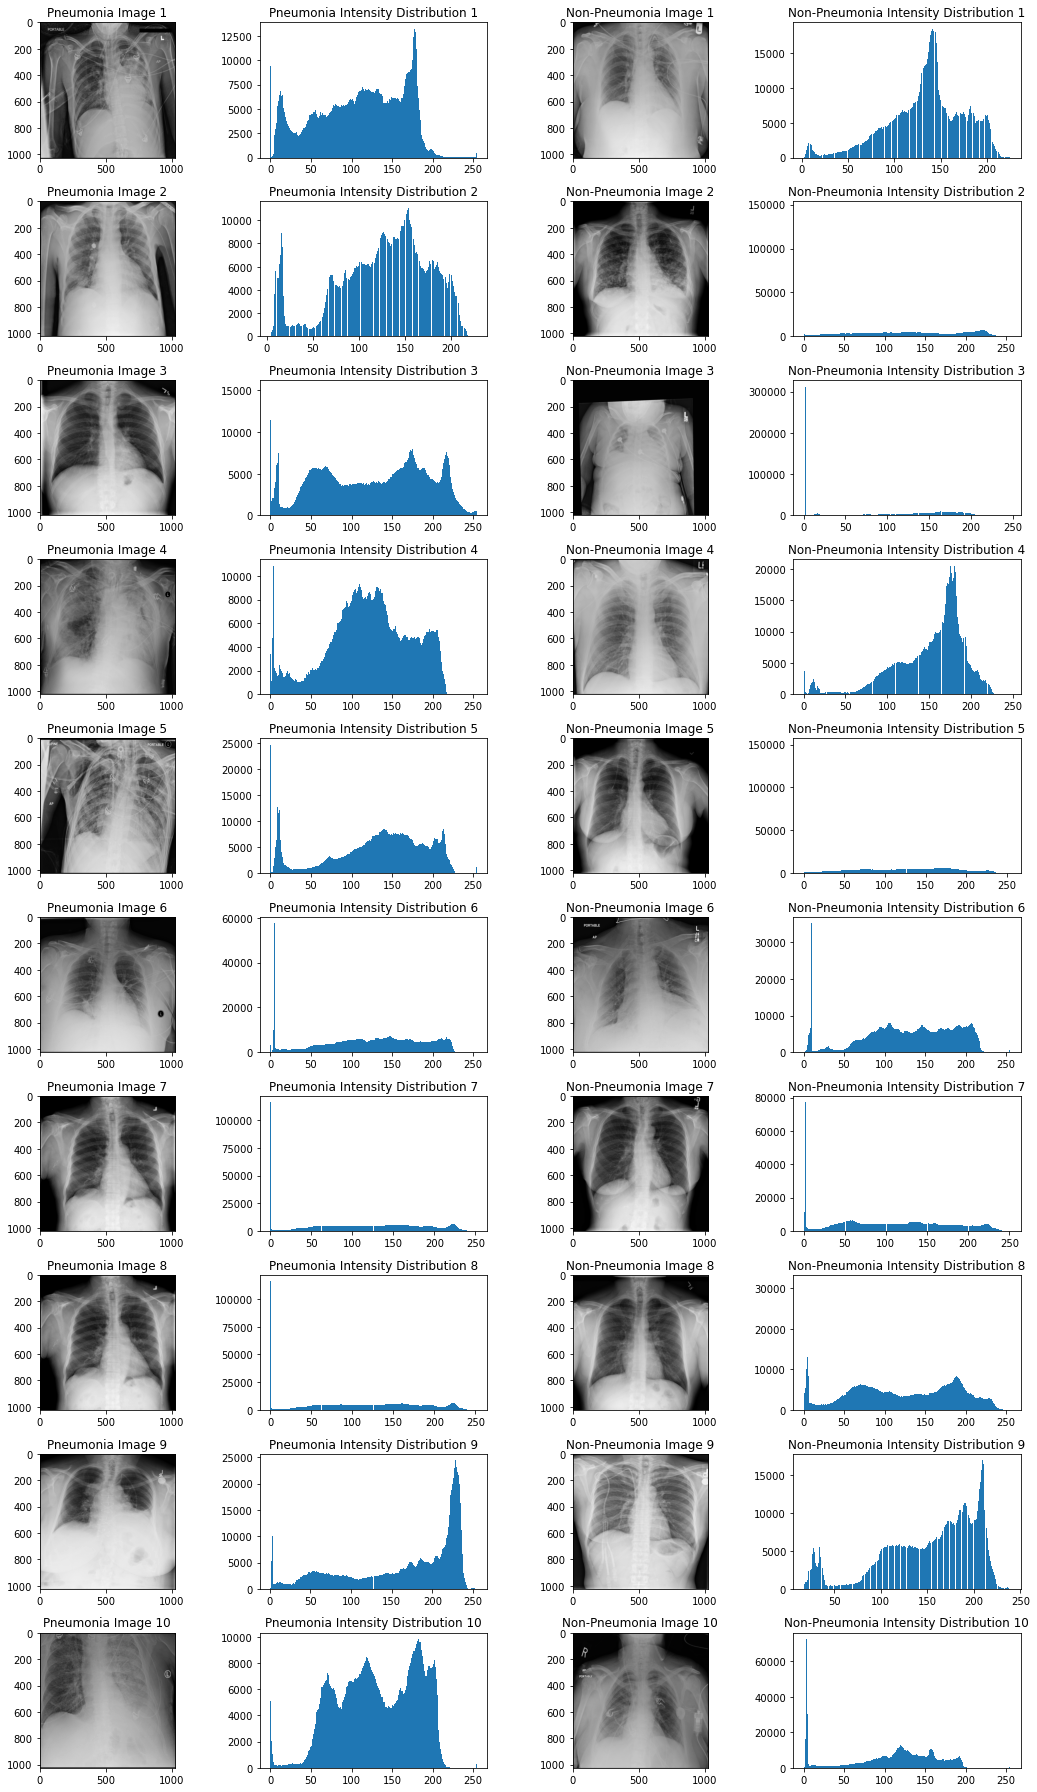

In [6]:
sample_df['path'] = sample_df['Image Index'].map({os.path.basename(x): x for x in glob('/data/images*/*/*.png')}.get)

for disease in ['Pneumonia']:
    sample_df[disease] = sample_df['Finding Labels'].apply(lambda x: 1 if disease in x else 0)

def load_image(image_path):
    img = Image.open(image_path).convert('L')
    return np.array(img)

def image_distr(case_df, non_case_df, disease, num_samples=10):
    fig, axs = plt.subplots(num_samples, 4, figsize=(15, 25))
    
    for i in range(num_samples):
        # Case 
        case_img_path = case_df['path'].sample(1).iloc[0]
        case_img_data = load_image(case_img_path)
        axs[i, 0].imshow(case_img_data, cmap='gray')
        axs[i, 0].set_title(f'{disease} Image {i+1}')
        axs[i, 1].hist(case_img_data.ravel(), bins=256)
        axs[i, 1].set_title(f'{disease} Intensity Distribution {i+1}')
        
        # Non-Case
        non_case_img_path = non_case_df['path'].sample(1).iloc[0]
        non_case_img_data = load_image(non_case_img_path)
        axs[i, 2].imshow(non_case_img_data, cmap='gray')
        axs[i, 2].set_title(f'Non-{disease} Image {i+1}')
        axs[i, 3].hist(non_case_img_data.ravel(), bins=256)
        axs[i, 3].set_title(f'Non-{disease} Intensity Distribution {i+1}')
        
    plt.tight_layout()
    plt.show()

case_df = sample_df[sample_df['Pneumonia'] == 1]
non_case_df = sample_df[sample_df['Pneumonia'] == 0]

image_distr(case_df, non_case_df, 'Pneumonia', num_samples=10)
